<a href="https://colab.research.google.com/github/chiheb764/DataAugmentation/blob/main/Detect_test_fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

def np2df(np_table):
    """" Convert a NumPy Array (my_data) to Pandas DataFrame"""
    (number_of_rows, number_of_colomns)=np_table.shape
    col=[]
    for i in range(number_of_colomns):
        col.append('Column_'+('00'+str(i))[-3:])
    # col

    rows=[]
    for i in range(number_of_rows):
        rows.append('Item_'+('00'+str(i))[-3:])
    #rows

    df = pd.DataFrame(np_table, columns = col, index = rows)
    return df

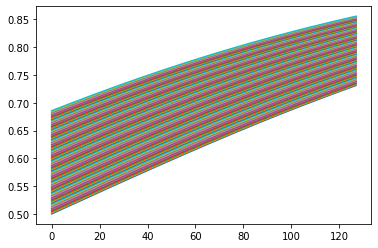

CPU times: user 237 ms, sys: 3.96 ms, total: 240 ms
Wall time: 259 ms


In [ ]:
%%time
import math
from numpy import ones
import random

def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig

#####################################################################
def load_data():
    my_data = ones((100,128))
    for i in range (100):
        for j in range(128):
            my_data[i][j] = sigmoid((i+j)/127)
    x = np2df(my_data)
    return x
#####################################################################
x = load_data()

from matplotlib import pyplot

# simple function

#define inputs
for i in range(x.shape[0]):
    outputs = x.iloc[i]
    inputs = range(len(outputs))
    pyplot.plot(inputs, outputs)

# plot the result

# pyplot.plot(range(len(x[0])), x[0])
# pyplot.plot(range(len(x[-1])), x[-1])
pyplot.show()
# x.shape


In [ ]:
def load_data():
    my_data = ones((100,128))
    for i in range (100):
        for j in range(128):
            my_data[i][j] = sigmoid((i+j)/127)
    x = np2df(my_data)
    return x
#####################################################################
x = load_data()
# print(x)
for i in range(x.shape[0]):
    outputs = x.iloc[i]
    inputs = range(len(outputs))
print(len(outputs))
x.shape[0]
#outputs

128


100

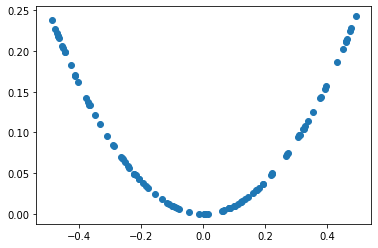

In [ ]:
# example of generating random samples from X^2
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot

# generate randoms sample from x^2
def generate_samples(n=100):
    # generate random inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2 (quadratic)
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    return hstack((X1, X2))

# generate samples
data = generate_samples()
# plot samples
pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()

# GAN

In [ ]:
data[0]

array([-0.20717121,  0.04291991])

## importing the modules // setting up the work-space

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import tensorflow
from tensorflow import keras
#from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam # Adam must be with Capital A
from keras.optimizers import adam_v2 # version 2 of importing Adam in the latest version of keras
# Adam = adam_v2.Adam(learning_rate=lr, decay=lr/epochs)
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt



<span style='color:cyan'>  #############################################################################</span>
* <span style='color:cyan'>   Define generator, discriminator, gan and other helper functions </span>
* <span style='color:cyan'>   Using Sequential method from Keras as it makes the definition of models easy. </span>
* <span style='color:cyan'>   We will use functional way of defining the model for the conditional gan </span>
* <span style='color:cyan'>   but sequential for descriminator and generator as they are straightforward. </span>

<span style='color:cyan'>  ############################################################################# </span>
    


## define the standalone discriminator model

In [ ]:
# Given an input image, the Discriminator outputs the likelihood of the image being real.
# Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(128)):
    model = Sequential()

    model.add(Input(shape = in_shape)) #128
    #model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64, activation="tanh"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(16, activation="tanh"))
    model.add(Dropout(0.15))

    model.add(Dense(8, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid')) #shape of 1

    # compile model
    #opt = Adam(learning_rate=0.005, beta_1=0.39)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8256      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0

## define the standalone generator model

In [ ]:
# #Given input of latent vector, the Generator produces an image.(here: 32x32)
# seed_size, for example, can be 16, (1D array of size 16)

def define_generator(seed_size = 16):    #seed_size is the dimension of the noise vector (e.g., 16)
    model = Sequential()
    # We will reshape input latent vector into 8x8 image as a starting point.
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    model.add(Input(shape = seed_size)) #128

    model.add(Dense(32, activation="relu"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64, activation="relu", kernel_initializer='he_uniform'))
    model.add(Dropout(0.1))

    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.1))

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.15))

    model.add(Dense(128, activation="relu", kernel_initializer='he_uniform'))
    # generate
    model.add(Dense(128, activation="relu"))
    return model  #Model not compiled as it is not directly trained like the discriminator.
                  #Generator is trained via GAN combined model.

test_gen = define_generator()
print(test_gen.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 128)              

## define the combined generator and discriminator model **"GAN"**, for updating the generator

In [ ]:
# Discriminator is trained separately so here only generator will be trained by keeping
# the discriminator constant.

def define_gan(generator, discriminator):
    discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
    # connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # compile model
    #opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer="adam")
    return model

In [ ]:
# def load_real_samples(data,n_samples):
#     #(trainX, _), (_, _) = load_data()
#     data = data.sample(frac=1., axis=0) #Shuffle the Dataset
#     #trainX = np2df(trainx)
#     X = data.iloc[:n_samples]
#     y = ones((n_samples,1))
#     return X, y

In [ ]:
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another
#half batch of fake images.
#For each real image we assign a label 1 and for fake we assign label 0.

def generate_real_samples(dataset, n_samples):
    # choose random vectors
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random vectors and assign it to X
    X = dataset.iloc[ix]
    # generate class labels and assign to y
    y = ones((n_samples, 1)) ##Label=1 indicating they are real
    return X, y



In [ ]:
# generate n_samples number of noise vectors as input for the generator
def generate_noise_vectors(seed_size, n_samples):
    # generate random points (noises)
    x_input = randn(seed_size * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, seed_size)
    return x_input



In [ ]:
# use the generator to generate n fake examples, with class labels
#Supply the generator, seed_size and number of samples as input.
#Use the above latent point generator to generate latent points.

def generate_fake_samples(generator, seed_size, n_samples):
    # generate noise vectors
    x_input = generate_noise_vectors(seed_size, n_samples)
    # predict using generator to generate fake samples.
    X = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake.
    y = zeros((n_samples, 1))  #Label=0 indicating they are fake
    return X, y

## evaluate the discriminator and plot real and fake points

In [ ]:
def summarize_performance(dataset, epoch, generator, discriminator, seed_size, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(dataset, n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, seed_size, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print("epoch, acc_real, acc_fake")
    print(epoch,")   ", acc_real,"  ,   ", acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(range(len(x_real.iloc[64])), x_real.iloc[64], color='red', label='real')
    pyplot.scatter(range(len(x_fake[64])), x_fake[64], color='blue', label='generated')
    # pyplot.scatter(x_fake.iloc[1], x_fake.iloc[1], color='blue')
    pyplot.legend()
    pyplot.show()

## train the generator and discriminator

In [ ]:
# We loop through a number of epochs to train our Discriminator by first selecting a random batch of images from our true/real dataset.
# Then, generating a set of images using the generator.
# Feed both set of images into the Discriminator.
# Finally, set the loss parameters for both the real and fake images, as well as the combined loss.

def train(g_model, d_model, gan_model, dataset, seed_size, n_epochs=1000, n_batch=64, taux_eval=0.1):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)   #the discriminator model is updated for a half batch of real samples
                                    #and a half batch of fake samples, combined a single batch.
    # manually enumerate epochs and bacthes.
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):

            # Train the discriminator on real and fake images, separately (half batch each)
            #Research showed that separate training is more effective.
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
            d_model.train_on_batch(X_real, y_real)

            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, seed_size, half_batch)
            # update discriminator model weights
            d_model.train_on_batch(X_fake, y_fake)

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

            # prepare noise vectors as input for the generator
            X_gan = generate_noise_vectors(seed_size, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
            y_gan = ones((n_batch, 1))

            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with seed_size as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
            # update the generator via the discriminator's error
            gan_model.train_on_batch(X_gan, y_gan)
            # evaluate the model every n_eval epochs
        if (i+1) % (int(n_epochs*taux_eval)) == 0:
            summarize_performance(dataset, i, g_model, d_model, seed_size)
            # Print losses on this batch
# # save the generator model
# g_model.save('./my_generator_2epochs.h5')



## Train the GAN

epoch, acc_real, acc_fake
99 )    1.0   ,    1.0


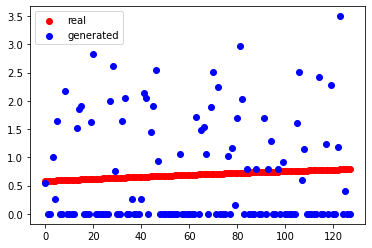

epoch, acc_real, acc_fake
199 )    1.0   ,    1.0


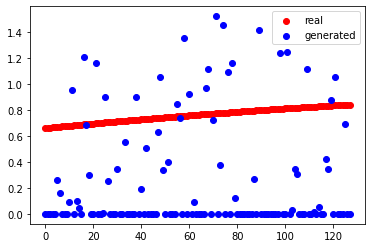

epoch, acc_real, acc_fake
299 )    1.0   ,    1.0


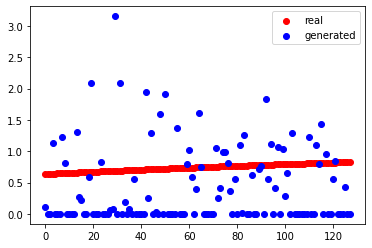

epoch, acc_real, acc_fake
399 )    1.0   ,    1.0


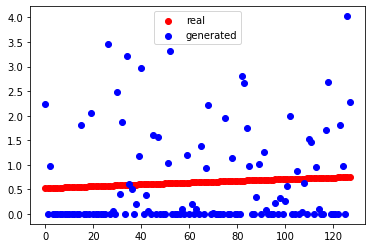

epoch, acc_real, acc_fake
499 )    1.0   ,    1.0


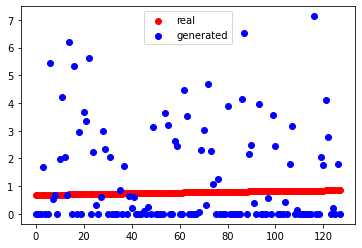

epoch, acc_real, acc_fake
599 )    1.0   ,    1.0


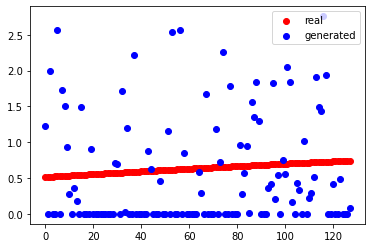

epoch, acc_real, acc_fake
699 )    1.0   ,    1.0


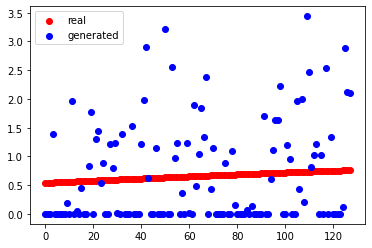

epoch, acc_real, acc_fake
799 )    1.0   ,    1.0


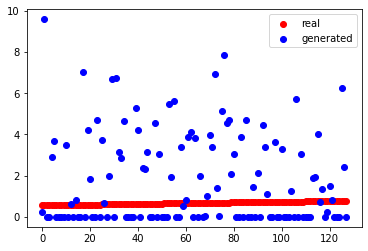

epoch, acc_real, acc_fake
899 )    1.0   ,    1.0


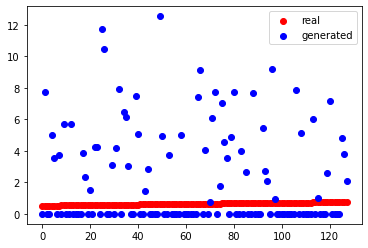

epoch, acc_real, acc_fake
999 )    1.0   ,    1.0


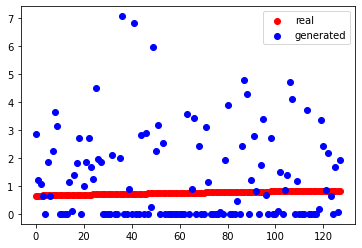

CPU times: user 1min 10s, sys: 2.01 s, total: 1min 12s
Wall time: 1min 10s


In [ ]:
%%time
# size of the noise vector
seed_size = 16
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(seed_size)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_data()
# train model
train(generator, discriminator, gan_model, dataset, seed_size,1000)

## Now, let us load the generator model and generate images